## Machine config

features-entry contains a list of a list with 26 items.
- length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))

- length of outer list: number of frames per data-point, e.g. 10 or 15, ...

In [ ]:
%cd /content
!git clone https://github.com/NVIDIA/apex
%cd /content/apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

# Audio classification the from-scratch way

Thanks to the SF Study Group practitioners & participants in the [Deep Learning for Audio fastai forum thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/), especially: [Molly Beavers](https://forums.fast.ai/u/marii/summary), [Simon Grest](https://forums.fast.ai/u/simonjhb/), [Stefano Giomo](https://forums.fast.ai/u/ste), [Thom Mackey](https://forums.fast.ai/u/ThomM), [Zach Caceres](https://forums.fast.ai/u/zachcaceres), [Harry Coultas Blum](https://forums.fast.ai/u/baz), & [Robert Bracco](https://forums.fast.ai/u/madeupmasters).

We're going to demonstrate the technique of classifying audio samples by first converting the audio into spectrograms, then treating the spectrograms as images. Once we've converted the spectrograms to images, the workflow is just the same as using imagenette or any other image classification task.

What do we need to do?
* Download the data
* Load the data
    - split the data to each element
    - split to train / valid
    - get label
    - zero pad
* Transform the data into spectrograms (skip)
* Load the audio data into a databunch such that we can use our previously-defined `learner` object

Still to come - 1D convolutional models, RNNs with audio… and more, with your contribution :)

# Download the data

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
!cp /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/ser_traindev.tar.gz /content/.
!mkdir /content/data
!mv /content/ser_traindev.tar.gz /content/data
%cd /content/data
!tar -xf /content/data/ser_traindev.tar.gz
%cd /content

/content/data
/content


In [2]:
!git clone https://github.com/fastai/course-v3/ /content/course-v3

Cloning into '/content/course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.10 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (3251/3251), done.
Checking out files: 100% (887/887), done.


In [3]:
# restart-run
%cd /content/course-v3/nbs/dl2

/content/course-v3/nbs/dl2


In [5]:
# restart-run
from exp.nb_12a import *

In [ ]:
# restart-run
%cd /content

/content


----

Skip this part. it needs only once when you prepare the dataset

In [ ]:
import json
with open('/content/data/data-v0/train.json') as f: train_json = json.load(f)
with open('/content/data/data-v0/dev.json') as f: dev_json = json.load(f)

- AUDIO
    - number of train (and valid) data: 7799
    - number of test data: 3341
- NLU
    - number of train (and valid) data: 10097
    - number of test data: 2886

In [ ]:
!cp /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/nlu_traindev.tar.gz /content/tmp
%cd /content/tmp

/content/tmp


In [ ]:
!tar -xf /content/tmp/nlu_traindev.tar.gz

In [ ]:
# export
def get_jsons(d):
    d = Path(d)
    with (d/'train.json').open() as f: train_json = json.load(f)
    with (d/'dev.json').open() as f: dev_json = json.load(f)
    return train_json, dev_json

In [ ]:
nlu_train, nlu_dev = get_jsons('/content/tmp')
list(nlu_train.keys())[-1], list(nlu_dev.keys())[-1]

In [ ]:
del nlu_train, nlu_dev; gc.collect()

809

In [9]:
train_path = data_root/'train'
(train_path).mkdir(parents=True, exist_ok=True)

dev_path = data_root/'dev'
(dev_path).mkdir(parents=True, exist_ok=True)

In [ ]:
data_root.ls()

[PosixPath('/content/data/ser/train'), PosixPath('/content/data/ser/dev')]

- The rule of naming
    - 'data/ser/train/{index}_y1_y2'
        - y1 : activation
        - y2 : valence

In [ ]:
for data_id, vals in train_json.items():
    v = tensor(vals['features'])
    torch.save(v, train_path/f"{data_id}_{vals['activation']}_{vals['valence']}.pt")

In [ ]:
for data_id, vals in dev_json.items():
    v = tensor(vals['features'])
    torch.save(v, dev_path/f"{data_id}.pt")

In [ ]:
del train_json, dev_json

In [ ]:
import gc
gc.collect()

619

# Load the data
- ~~split the data to each element~~
- split to train / valid (using DataBlock of fastai)
- get label
- zero pad

In [11]:
data_root = Path('/content/data/data/ser')

In [ ]:
# save for later

!cp -R /content/data /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/data

In [10]:
!cp -R /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/data /content/data/

In [12]:
train_path, dev_path = data_root/'train', data_root/'dev'

In [13]:
train_path.ls().__len__(), dev_path.ls().__len__()

(7800, 3342)

We rely heavily on [torchaudio](https://github.com/pytorch/audio) - which you'll have to compile to install.

In [14]:
audios = get_files(train_path)

In [15]:
# restart-run
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)

In [16]:
al=AudioList.from_files(train_path); al

AudioList (7800 items)
[PosixPath('/content/data/data/ser/train/7540_1_0.pt'), PosixPath('/content/data/data/ser/train/2059_1_1.pt'), PosixPath('/content/data/data/ser/train/5591_1_1.pt'), PosixPath('/content/data/data/ser/train/6793_1_1.pt'), PosixPath('/content/data/data/ser/train/5845_0_0.pt'), PosixPath('/content/data/data/ser/train/6578_0_0.pt'), PosixPath('/content/data/data/ser/train/384_1_0.pt'), PosixPath('/content/data/data/ser/train/6909_1_1.pt'), PosixPath('/content/data/data/ser/train/4344_1_1.pt'), PosixPath('/content/data/data/ser/train/6534_0_1.pt')...]
Path: /content/data/data/ser/train

In [17]:
al[0].shape

torch.Size([243, 26])

In [ ]:
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))

In [29]:
%cd /content/

/content


In [37]:
plt.imsave('test3.png', al[0])

# save as an image

In [49]:
img = PIL.Image.open('test3.png')

In [50]:
img

In [55]:
# img.resize((128, 128))
item = to_float_tensor(to_byte_tensor(img))
item.shape

torch.Size([4, 243, 26])

TypeError: ignored

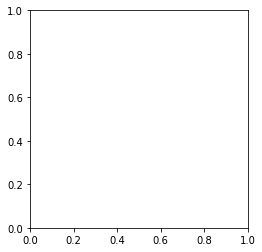

In [56]:
plt.imshow(item)

In [64]:
item2 = to_float_tensor(to_byte_tensor(img.convert('RGB')))

In [65]:
item2.shape

torch.Size([3, 243, 26])

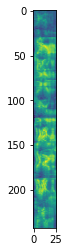

In [66]:
plt.imshow(item2.permute(1,2,0))

- we have two labels, which are activation and valence. I will first try to classify them separately.

In [ ]:
# restart-run
def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return re.findall(pat, str(fn))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]

In [ ]:
# restart-run
label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat)
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [ ]:
re.findall(label_pat, str(list(sd.train)[0]))

['1', '0']

In [ ]:
ll

SplitData
Train: LabeledData
x: AudioList (6193 items)
[PosixPath('/content/data/ser/train/1734_1_0.pt'), PosixPath('/content/data/ser/train/7264_1_1.pt'), PosixPath('/content/data/ser/train/5083_1_1.pt'), PosixPath('/content/data/ser/train/2247_1_1.pt'), PosixPath('/content/data/ser/train/1744_1_1.pt'), PosixPath('/content/data/ser/train/4635_1_0.pt'), PosixPath('/content/data/ser/train/4747_0_1.pt'), PosixPath('/content/data/ser/train/3828_1_1.pt'), PosixPath('/content/data/ser/train/529_1_1.pt'), PosixPath('/content/data/ser/train/2975_1_1.pt')...]
Path: /content/data/ser/train
y: ItemList (6193 items)
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1...]
Path: /content/data/ser/train

Valid: LabeledData
x: AudioList (1607 items)
[PosixPath('/content/data/ser/train/4310_0_0.pt'), PosixPath('/content/data/ser/train/5159_1_0.pt'), PosixPath('/content/data/ser/train/4662_1_0.pt'), PosixPath('/content/data/ser/train/2330_0_0.pt'), PosixPath('/content/data/ser/train/2696_1_0.pt'), PosixPath('/content/data/s

In [ ]:
emotion_labeler = partial(re_labeler, pat=label_pat)
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())
class ToCuda(Transform):
    _order=10
    def __call__(self, ad): return ad.cuda()

In [ ]:
ToCuda()(ll.train[0][0]).type()

'torch.cuda.FloatTensor'

In [ ]:
import torchaudio
from torchaudio import transforms
dir(transforms)

['AmplitudeToDB',
 'Callable',
 'ComplexNorm',
 'ComputeDeltas',
 'F',
 'Fade',
 'FrequencyMasking',
 'GriffinLim',
 'InverseMelScale',
 'InverseSpectrogram',
 'LFCC',
 'MFCC',
 'MVDR',
 'MelScale',
 'MelSpectrogram',
 'MuLawDecoding',
 'MuLawEncoding',
 'Optional',
 'PSD',
 'PitchShift',
 'RNNTLoss',
 'Resample',
 'SlidingWindowCmn',
 'SpectralCentroid',
 'Spectrogram',
 'Tensor',
 'TimeMasking',
 'TimeStretch',
 'Vad',
 'Vol',
 '_AxisMasking',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_apply_sinc_resample_kernel',
 '_get_mat_trace',
 '_get_sinc_resample_kernel',
 'math',
 'torch',
 'warnings']

- let's see the distribution of frames to pad

In [ ]:
len_dist = [sd.train[idx].shape[0] for idx, item in enumerate(sd.train)]

In [ ]:
max(len_dist)

1707

(array([3.490e+03, 1.812e+03, 6.000e+02, 1.860e+02, 7.700e+01, 1.600e+01, 5.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([  30. ,  197.7,  365.4,  533.1,  700.8,  868.5, 1036.2, 1203.9, 1371.6, 1539.3, 1707. ]),
 <a list of 10 Patch objects>)

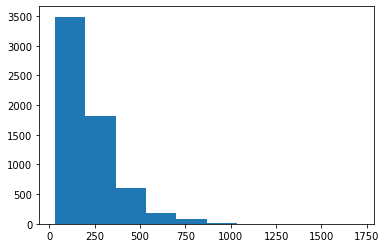

In [ ]:
plt.hist(len_dist)

- let me see the 80 percent point

In [ ]:
get_pct = lambda ls, n: sorted(ls)[int(len(ls)*n)]

In [ ]:
get_pct(len_dist, 0.90)

421

In [ ]:
# number of time frames and filter banks
t, fb = sd.train[0].shape; t, fb

(197, 26)

In [ ]:
pad_size = 422 - t; pad_size

225

In [ ]:
class PadProcessor(Processor):
    def __init__(self): self.max_len = max_len

    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            # save original length of frames
            self.itov  = {k: items[k].shape[0] for k,v in enumerate(items)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):
        t, fb = ad.shape
        pad_size = self.max_len - t
        return torch.concat((item, torch.zeros(pad_size, fb)))

    # def deprocess(self, idxs):
    #     assert self.vocab is not None
    #     return [self.deproc1(idx) for idx in idxs]
    # def deproc1(self, idx): return self.vocab[idx]

In [ ]:
torch.concat((sd.train[0],torch.zeros(pad_size, fb))).shape

torch.Size([422, 26])

In [ ]:
class Pad():
    _order = 11
    def __init__(self, max_len):
        self.max_len = max_len
    def __call__(self, ad):
        # number of time frames and filter banks
        t, fb = ad.shape
        pad_size = self.max_len - t
        torch.zeros(pad_size, fb)
        return torch.concat((ad, torch.zeros(pad_size, fb)))

In [ ]:
Pad(422)(sd.train[0]).shape

torch.Size([422, 26])

In [ ]:
pad_90 = Pad(get_pct(len_dist, 0.9))
tfms = [ToCuda(), pad_90]
al = AudioList.from_files(train_path, tfms=tfms)
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [ ]:
tfms = [ToCuda()]
al = AudioList.from_files(train_path, tfms=tfms)
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor(), proc_x = partial(Pad(get_pct(len_dist, 0.9))))

In [ ]:
bs=64
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))

RuntimeError: ignored

In [ ]:
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [ ]:
# x,y = next(iter(data.train_dl))
# I can not run this as the size of batcehs are different. 

In [ ]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
loss_func = LabelSmoothingCrossEntropy()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr),
ParamScheduler('mom', sched_mom)]

In [ ]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func)